In [10]:
import numpy as np
import matplotlib.pyplot as plt

from stacked_mnist import StackedMNISTData, DataMode
from models.vae import VAE
from models.mnist_classifier import MNISTClassifier

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from utils import *

In [11]:
# Using the provided mnist dataset class
gen = StackedMNISTData(mode=DataMode.MONO_BINARY_COMPLETE, default_batch_size=9)

train_data = gen.get_full_data_set(training=True)
test_data = gen.get_full_data_set(training=False)

In [12]:
train_data[0].shape, test_data[0].shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

(60000, 28, 28, 1) (60000,)
(10000, 28, 28, 1) (10000,)
(28, 28, 1)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
9


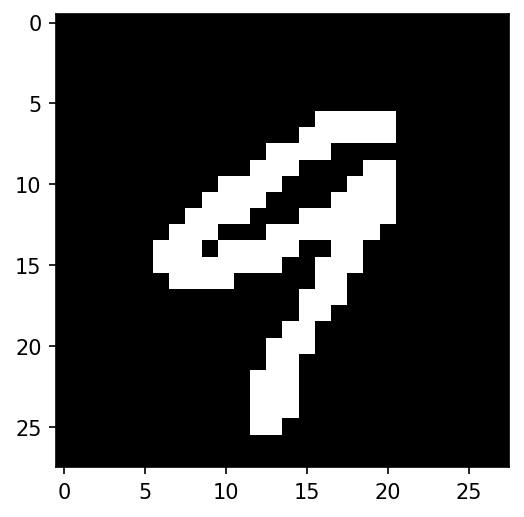

In [13]:
x_train, y_train = train_data
x_test, y_test = test_data
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Convert y_train and y_test into one-hot vectors
y_train = to_one_hot(y_train)
y_test = to_one_hot(y_test)

rand = np.random.randint(0, x_train.shape[0])
img = x_train[rand]
label = y_train[rand]
print(img.shape)

print(label)
print(label.argmax())
plt.figure(figsize=(6, 4), dpi=150)
plt.imshow(img.squeeze(), cmap="gray")

In [14]:
# Create pytorch dataloaders from x_train and y_train
x_train = torch.from_numpy(x_train.astype(np.float32)).permute(0, 3, 1, 2)
y_train = torch.from_numpy(y_train.astype(np.float32))

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

# Create pytorch dataloaders from x_test and y_test
x_test = torch.from_numpy(x_test.astype(np.float32)).permute(0, 3, 1, 2)
y_test = torch.from_numpy(y_test.astype(np.float32))

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(dataset=test_dataset, batch_size=64)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [16]:
def VAELoss(bce_loss, mu, logvar):
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [17]:
# Training setup
model = VAE(in_channels=1)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss(reduction="sum")

# Training the autoencoder
val_losses = []

for epoch in range(100):
    model.train()
    total_loss = 0
    for images, _ in train_loader:
        images = images.to(device)
        optimizer.zero_grad()
        rec, mu, logvar = model(images)
        bce_loss = criterion(rec, images)
        loss = VAELoss(bce_loss, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch: {epoch}, Loss: {total_loss / len(train_loader)}")

    # Test on test data
    model.eval()
    test_loss_sum = 0
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            rec, mu, logvar = model(images)
            bce_loss = criterion(rec, images)
            loss = VAELoss(bce_loss, mu, logvar)
            test_loss_sum += loss.item()
        
        test_loss = test_loss_sum / len(test_loader)
        print(f"Test Loss: {test_loss}")
        if (len(val_losses) > 5) and all(test_loss >= x for x in val_losses[-3:]):
            print("Early Stopping...")
            break
        val_losses.append(test_loss)


Epoch: 0, Loss: 12285.65336508029
Test Loss: 9210.675149905454
Epoch: 1, Loss: 8381.465904121967
Test Loss: 7620.691236751095
Epoch: 2, Loss: 7386.666538783482
Test Loss: 7195.468626374652
Epoch: 3, Loss: 6956.280283328058
Test Loss: 6750.7518411624205
Epoch: 4, Loss: 6621.129508532949
Test Loss: 6441.865928698498
Epoch: 5, Loss: 6388.582069250567
Test Loss: 6273.481688675607
Epoch: 6, Loss: 6249.779917897955
Test Loss: 6100.305469683021
Epoch: 7, Loss: 6139.247873269673
Test Loss: 6033.843110880274
Epoch: 8, Loss: 6033.4051203941235
Test Loss: 5873.380230363007
Epoch: 9, Loss: 5955.072956402419
Test Loss: 5852.698997934913
Epoch: 10, Loss: 5890.207792302439
Test Loss: 5789.627365209494
Epoch: 11, Loss: 5841.960287846482
Test Loss: 5784.010381419188
Epoch: 12, Loss: 5803.340249783449
Test Loss: 5737.423543553444
Epoch: 13, Loss: 5766.9006415328495
Test Loss: 5683.708010145054
Epoch: 14, Loss: 5731.761587569963
Test Loss: 5645.8932413477805
Epoch: 15, Loss: 5703.077519593717
Test Loss: 

In [27]:
# Save the VAE model
torch.save(model.state_dict(), "trained_models/vae.pt")

In [18]:
model

VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=256, out_features=128, bias=True)
  )
  (fc_mu): Linear(in_features=128, out_features=16, bias=True)
  (fc_log_var): Linear(in_features=128, out_features=16, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Unflatten(dim=1, unflattened_size=(64, 2, 2))
    (5): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (6): ReLU()
    (7): Con

In [25]:
model.eval()

with torch.no_grad():
    im, tgt = iter(test_loader).next()
    im = im.to(device)
    pred, _, _ = model(im)

pred = pred[5]

pred.shape

torch.Size([1, 28, 28])

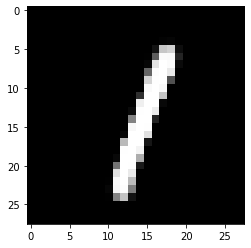

In [26]:
plt.imshow(pred.cpu().numpy().squeeze(), cmap="gray")